In [120]:
from phidl import Device, CrossSection, Path
import phidl.path as pp
import phidl.geometry as pg
import numpy as np
from phidl import quickplot as qp
from copy import deepcopy
import matplotlib.pyplot as plt

Note that all units here are in microns, not millimeters.

We begin by drawing the feedline with wirebonds. We then draw the resonator.


In [121]:
cpw_width = 10
cpw_gap = 10

wirebond_pad_width = 100
wirebond_pad_height = 100
wirebond_pad_taper_length = 50
wirebond_gap = 30

resonator_width = 500
resonator_length = 8100
resonator_meander_space = 100
resonator_fillet = 10

# note, we can instantiate the coupler independent of the resonator in order to do S31 simulations
coupler_length = 100
coupler_gap = 20
coupler_length_normal = 100 # this is the length away from the coupler for the three-port simulation

# these are not accessible from the LLM, but are important for sonnet simulations
cutout_layer = 11
cad_layer = 12

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


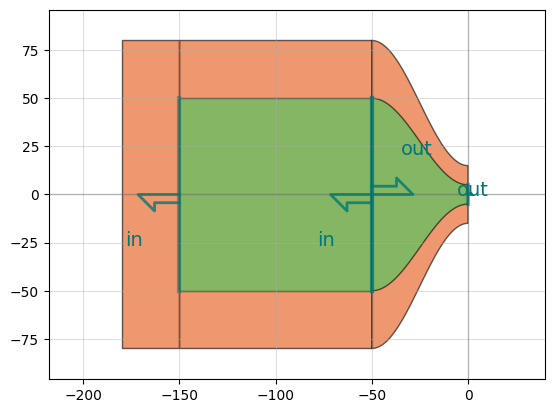

In [122]:
device = Device("resonator_chip")

wirebond = Device("wirebond")
wirebond_pad_path = pp.straight(wirebond_pad_width)
wirebond_pad_xc = CrossSection()
wirebond_pad_xc.add(width=wirebond_pad_height, layer=cad_layer, name = 'metal', ports = ('in', 'out'))
wirebond_pad_xc.add(width=wirebond_pad_height + 2*wirebond_gap, name = 'cutout', layer=cutout_layer)
wirebond_pad = wirebond_pad_path.extrude(wirebond_pad_xc)

cpw_xc = CrossSection()
cpw_xc.add(width=cpw_width, layer=cad_layer, name = 'metal', ports = ('in', 'out'))
cpw_xc.add(width=cpw_width + 2*cpw_gap, name = 'cutout', layer=cutout_layer)

wirebond_cpw_trans_xc = pp.transition(wirebond_pad_xc, cpw_xc, width_type = 'sine')
wirebond_cpw_trans_path = pp.straight(wirebond_pad_taper_length)
wirebond_cpw_trans = wirebond_cpw_trans_path.extrude(wirebond_cpw_trans_xc)

wirebond << wirebond_pad
wirebond << wirebond_cpw_trans.move((wirebond_pad_width, 0))

wirebond_spacer = pg.rectangle(size=(wirebond_gap, wirebond_pad_height + 2*wirebond_gap), layer=cutout_layer).move((-wirebond_gap, -(wirebond_pad_height + 2*wirebond_gap)/2))
wirebond << wirebond_spacer

wirebond.move((-wirebond_pad_width - wirebond_pad_taper_length, 0))

qp(wirebond)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


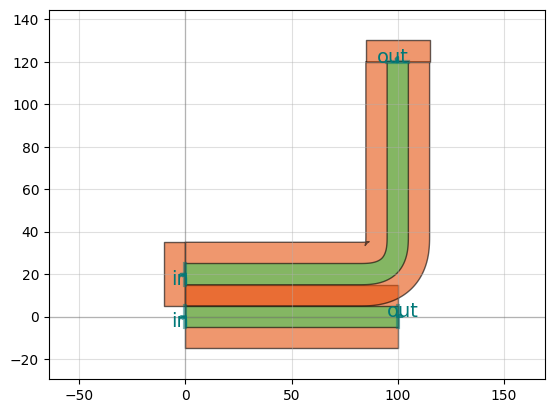

In [123]:
# now we draw the coupler

coupler_primary_path = pp.straight(coupler_length)
coupler_primary = coupler_primary_path.extrude(cpw_xc)

coupler_secondary_path_pts = [(0, coupler_gap), (coupler_length, coupler_gap), (coupler_length, coupler_gap + coupler_length_normal)]
coupler_secondary_path = pp.smooth(coupler_secondary_path_pts, radius = resonator_fillet, corner_fun = pp.euler)
coupler_secondary = coupler_secondary_path.extrude(cpw_xc)

coupler_endpoint = (coupler_length, coupler_gap + coupler_length_normal)

coupler_secondary_gap = pg.rectangle(size=(cpw_gap, cpw_width + 2*cpw_gap), layer=cutout_layer).move((-cpw_gap, coupler_gap-(cpw_width + 2*cpw_gap)/2))

coupler_secondary_gap2 = pg.rectangle(size=(cpw_width + 2*cpw_gap, cpw_gap), layer=cutout_layer).move((coupler_endpoint[0] - (cpw_width + 2*cpw_gap)/2, coupler_endpoint[1]))

coupler = Device("coupler")
coupler << coupler_primary
coupler << coupler_secondary
coupler << coupler_secondary_gap
coupler << coupler_secondary_gap2
qp(coupler)



In [124]:
# lastly we draw the meander


# dynamically generate points to create the meander path. Note that we need to keep this within meander_width. We will go back and forth between the two edges of the meander.

resonator_length_current = coupler_secondary_path.length()

next_meander_direction = 'left'
meander_x_right = coupler_endpoint[0]
meander_x_left = coupler_endpoint[0] - resonator_width
meander_y = coupler_endpoint[1]


meander_start_x = coupler_endpoint[0] + cpw_width/2
meander_start_y = coupler_endpoint[1] - cpw_width/2

meander_points = [(meander_start_x, meander_start_y)]

while resonator_length_current + resonator_width + resonator_meander_space < resonator_length:
    if next_meander_direction == 'left':
        meander_points.append((meander_x_left, meander_y))
        next_meander_direction = 'right'
        meander_y += resonator_meander_space
        meander_points.append((meander_x_left, meander_y))

    else:
        meander_points.append((meander_x_right, meander_y))
        next_meander_direction = 'left'
        meander_y += resonator_meander_space
        meander_points.append((meander_x_right, meander_y))

    resonator_length_current += resonator_width + resonator_meander_space

remaining_resonator_length = resonator_length - resonator_length_current

if remaining_resonator_length > 2*resonator_fillet: # otherwise so small we can ignore
    if next_meander_direction == 'left':
        meander_points.append((meander_x_right - remaining_resonator_length, meander_y))
    if next_meander_direction == 'right':
        meander_points.append((meander_x_left + remaining_resonator_length, meander_y))

else:
    print("remaining we have ", remaining_resonator_length) # return this in the MCP function as a remaining resonator length parameter

resonator_path = pp.smooth(meander_points, radius = resonator_fillet, corner_fun = pp.euler)

resonator_meander = resonator_path.extrude(cpw_xc)


In [125]:
# now we can construct the full chip

resonator_bbox = resonator_meander.bbox
print(resonator_bbox)

# now we calculate the sonnet box dimensions and the feedline dimensions

# feedline should have 500 um gap on either side of resonator bbox

feedline_xmin = resonator_bbox[0][0] - 500
feedline_xmax = resonator_bbox[1][0] + 500

# then the chip boundary should be 1000 um away from the feedline max y, and -500 um away from the feedline min y

chip_boundary_xmin = feedline_xmin - 1000
chip_boundary_xmax = feedline_xmax + 1000
chip_boundary_ymin = resonator_bbox[1][1] + 500
chip_boundary_ymax = - 500

sonnet_boundary_xmin = feedline_xmin + 250
sonnet_boundary_xmax = feedline_xmax - 250
sonnet_boundary_ymin = resonator_bbox[1][1] + 250
sonnet_boundary_ymax = - 250


# we draw the feedline
drawn_cad = Device("drawn_cad")

feedline_path = pp.straight(feedline_xmax - feedline_xmin)
feedline = feedline_path.extrude(cpw_xc).move((feedline_xmin, 0))

drawn_cad << feedline
drawn_cad << resonator_meander
drawn_cad << coupler
drawn_cad << deepcopy(wirebond).move((feedline_xmin, 0))
drawn_cad << deepcopy(wirebond).rotate(180).move((feedline_xmax, 0))


# now we construct the chip

chip = Device("chip")

chip << pg.rectangle(size=(chip_boundary_xmax - chip_boundary_xmin, chip_boundary_ymax - chip_boundary_ymin), layer=10).move((chip_boundary_xmin, chip_boundary_ymin))
chip << drawn_cad

# lastly we export the sonnet simulation version and full version of the chip to gds

chip.write_gds("bare_chip.gds")

import manipulate_GDS

manipulate_GDS.slice_and_boolean("bare_chip.gds", "full_chip.gds", 
                                 np.array([[chip_boundary_xmin, chip_boundary_ymin], [chip_boundary_xmax, chip_boundary_ymax]]), 
                                 {"layer 1": [10, 1], "layer 2": [cutout_layer, cad_layer], "layer out": [1, 1], "operation": ["not", "or"]}, [1])


manipulate_GDS.slice_and_boolean("bare_chip.gds", "sonnet_chip.gds", 
                                 np.array([[sonnet_boundary_xmin, sonnet_boundary_ymin], [sonnet_boundary_xmax, sonnet_boundary_ymax]]), 
                                 {"layer 1": [10, 1], "layer 2": [cutout_layer, cad_layer], "layer out": [1, 1], "operation": ["not", "or"]}, [1])



[[-415.          100.00073517]
 [ 115.         1435.        ]]
slicing polygons from layer 10, datatype 0
slicing polygons from layer 12, datatype 0
slicing polygons from layer 11, datatype 0
preforming boolean 1
preforming boolean 2
adding polygons on layer 1, datatype 0...
slicing polygons from layer 10, datatype 0
slicing polygons from layer 12, datatype 0
slicing polygons from layer 11, datatype 0
preforming boolean 1
preforming boolean 2
adding polygons on layer 1, datatype 0...


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


130.0


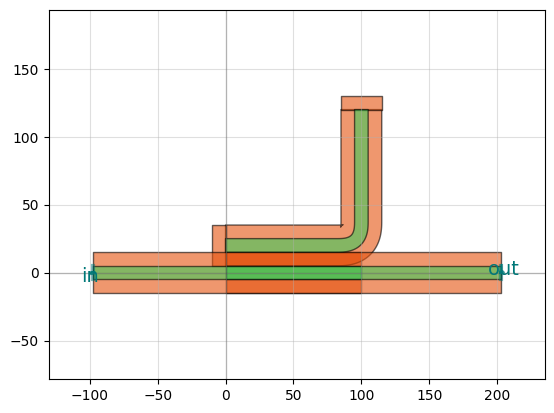

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


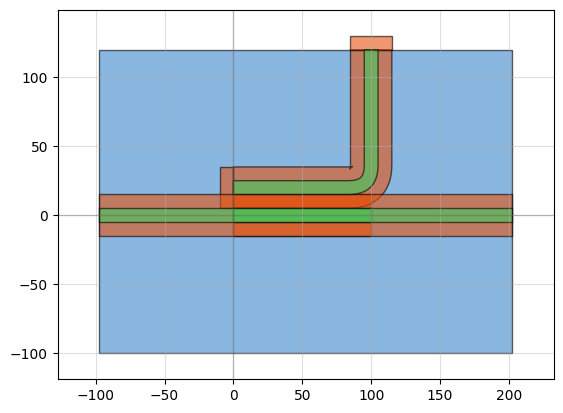

slicing polygons from layer 12, datatype 0
slicing polygons from layer 11, datatype 0
slicing polygons from layer 10, datatype 0
preforming boolean 1
preforming boolean 2
adding polygons on layer 1, datatype 0...


In [161]:
# we also need to generate the coupler by itself for Sonnet simulations.

coupler_sonnet_sim = Device("coupler_sonnet_sim")
coupler_sonnet_sim << coupler
coupler_feedline = pp.straight(coupler_length + 200).extrude(cpw_xc).move((-(coupler_length+200)/2+coupler.center[0],0))
coupler_feedline_bbox = coupler_feedline.bbox
coupler_sonnet_sim << coupler_feedline

coupler_chip = Device("coupler")

print(coupler_sonnet_sim.ymax)

coupler_chip_groundplane = pg.rectangle(size=(coupler_sonnet_sim.xsize, coupler_sonnet_sim.ymax -cpw_gap + 100), layer=10)
coupler_chip_groundplane.move((-coupler_sonnet_sim.xsize/2 + coupler_sonnet_sim.center[0],  - 100 ))
coupler_chip << coupler_sonnet_sim
coupler_chip << coupler_chip_groundplane
qp(coupler_sonnet_sim)
qp(coupler_chip)

coupler_chip.write_gds("coupler_chip.gds")

manipulate_GDS.slice_and_boolean("coupler_chip.gds", "sonnet_coupler.gds", 
                                 coupler_chip.bbox, 
                                 {"layer 1": [10, 1], "layer 2": [cutout_layer, cad_layer], "layer out": [1, 1], "operation": ["not", "or"]}, [1])



Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


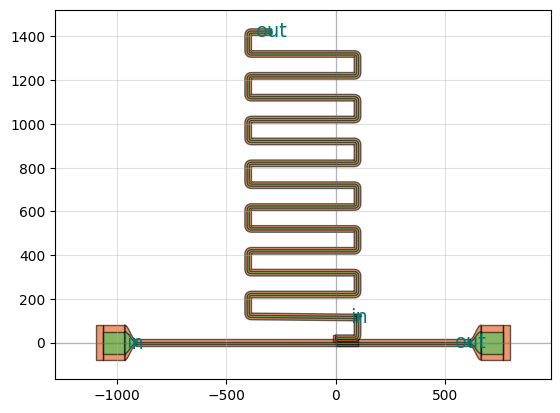

In [127]:
# this should be another MCP function that returns an image of the chip

from quickplot_nosave import quickplot_noshow

quickplot_noshow(drawn_cad)